# Setup

In [1]:
!pip install transformers==3.0.2 -q

     |████████████████████████████████| 778kB 8.9MB/s 
     |████████████████████████████████| 1.1MB 30.8MB/s 
     |████████████████████████████████| 3.0MB 51.5MB/s 
     |████████████████████████████████| 890kB 58.1MB/s 


In [2]:
import pandas as pd
import os
from google.colab import files
import random
from tqdm.notebook import tqdm
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import pickle
import numpy as np
from sklearn import metrics
from pathlib import Path

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!git clone https://gitlab.clarin-pl.eu/ajanz/poleval20-wsd

Cloning into 'poleval20-wsd'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 55 (delta 15), reused 32 (delta 8), pack-reused 0
Unpacking objects: 100% (55/55), done.


In [5]:
!7z x poleval20-wsd/testdata.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 401505 bytes (393 KiB)

Extracting archive: poleval20-wsd/testdata.7z
--
Path = poleval20-wsd/testdata.7z
Type = 7z
Physical Size = 401505
Headers Size = 2293
Method = LZMA:23
Solid = +
Blocks = 1

  0%    Everything is Ok

Folders: 3
Files: 129
Size:       1679954
Compressed: 401505


In [6]:
pd.options.mode.chained_assignment = None  # default='warn'

In [7]:
!mkdir testresults
!mkdir testresults/kpwr
!mkdir testresults/sherlock

# Helpers

In [8]:
def create_tuple(example):
  l1, l2, e1, e2 = example['l1'], example['l2'], example['e1'], example['e2'] 
  return (l1 +': ' + e1, l2 + ': ' + e2)



In [9]:
class AverageMeter:
    """
    Computes and stores the average and current value
    """

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
class EarlyStopping:
    def __init__(self, patience=7, mode="max", delta=0.0001):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                "EarlyStopping counter: {} out of {}".format(
                    self.counter, self.patience
                )
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(
                "Validation score improved ({} --> {}). Saving model!".format(
                    self.val_score, epoch_score
                )
            )
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

In [11]:
def ctlns(sent):
  return len(sent.split(' '))

ctlns('ja cie nie moge')

4

In [12]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

# Data Munging

In [13]:
ls poleval20-wsd/data

lemmas.txt            lexicalunits.txt  synset_defs_examples.txt  synsets.txt
lexicalunit_rels.txt  skladnica-ccl.7z  synset_rels.txt


In [14]:
path = 'testdata/kpwr/00099883.conll'
df = pd.read_csv(path, sep='\t')

In [15]:
sentences_kpwr = []
for fname in os.listdir('testdata/kpwr'):
  fname = 'testdata/kpwr/' + fname
  df = pd.read_csv(fname, sep='\t')
  s = ''
  for i in range(len(df)):
    s = s + df.ORTH.loc[i] + ' '
  sentences_kpwr.append(s)

In [16]:
df_kpwr = pd.DataFrame(sentences_kpwr, columns=['sentence'])
df_kpwr['length'] = df_kpwr['sentence'].apply(ctlns)
df_kpwr.head()

,sentence,length
0,"Błogosławię moją biegłość żeglarską , dzięki k...",423
1,Przygotowywanie uczniów do wykorzystania wiedz...,359
2,kod powrotu ostanio wykonywanego polecenia PID...,420
3,4 . SWOBODNY PRZEPŁYW KAPITAŁU Traktat o Unii ...,416
4,"W rzeczy samej , disneyowska interpretacja pro...",688


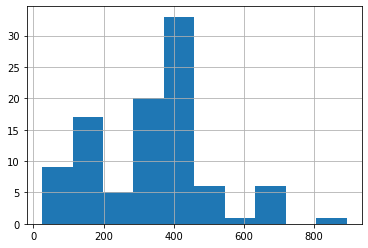

In [17]:
df_kpwr.length.hist()

In [18]:
# df_kpwr.to_csv('kpwr.csv', index=False)

In [19]:
# files.download('kpwr.csv')

In [20]:
sentences_sherlock = []
for fname in os.listdir('testdata/sherlock'):
  fname = 'testdata/sherlock/' + fname
  df = pd.read_csv(fname, sep='\t')
  s = ''
  for i in range(len(df)):
    s = s + df.ORTH.loc[i] + ' '
  sentences_sherlock.append(s)

In [21]:
df_sherlock = pd.DataFrame(sentences_sherlock, columns=['sentence'])
df_sherlock['length'] = df_sherlock['sentence'].apply(ctlns)
df_sherlock.head()

,sentence,length
0,"Stoke Moran ? - zapytał . Tak jest , proszę pa...",325
1,Zmarła raptem dwa lata temu i to właśnie o jej...,256
2,"A może trucizna ? Lekarze przebadali ją , ale ...",347
3,"Gwałtowny temperament , graniczący z manią , b...",252
4,"Mówiąc to , chwycił leżącą na kolanach niebosz...",292


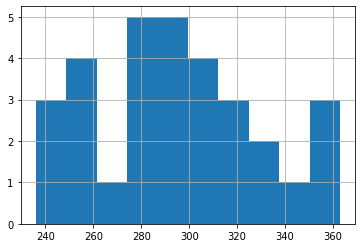

In [22]:
df_sherlock.length.hist()

In [23]:
df_sherlock.length.sum(), df_kpwr.length.sum()

(9118, 32620)

In [24]:
len(df_sherlock), len(df_kpwr)

(31, 98)

In [25]:
# df_sherlock.to_csv('sherlock.csv', index=False)

In [26]:
# files.download('sherlock.csv')

In [27]:
f_lemmas = 'poleval20-wsd/data/lemmas.txt'
f_synsets = 'poleval20-wsd/data/synsets.txt'
f_l2s = 'poleval20-wsd/data/lexicalunits.txt'
f_examples = 'poleval20-wsd/data/synset_defs_examples.txt'

df_lemmas = pd.read_csv(f_lemmas, names=['lemma', 'POS'])
df_synsets = pd.read_csv(f_synsets, names=['synset'])
df_l2s = pd.read_csv(f_l2s, sep='\t', names=['li', 'si'])
df_examples = pd.read_csv(f_examples, sep='\t', names=['synset', 'example'])
df_lemmas['li'] = df_lemmas.index
df_lemmas['li'] = df_lemmas['li'].apply(lambda i: i+1)
df_synsets['si'] = df_synsets.index
df_synsets['si'] = df_synsets['si'].apply(lambda i: i+1)
df_all = pd.merge(df_l2s, df_lemmas, how='left', on='li')
df_all = pd.merge(df_all, df_synsets, how='left', on='si')
df_all = pd.merge(df_all, df_examples, how='left', on='synset')
del df_all['li']
del df_all['si']

In [28]:
df_all = df_all[df_all['lemma'].notna()]

In [29]:
def contains_underscore(string):
  return '_' in string

def contains_space(string):
  return ' ' in string

contains_underscore('asdf_df'), contains_space('asdfasdfa_dsf')

(True, False)

In [30]:
df_all['contains_underscore'] = df_all['lemma'].apply(contains_underscore)
df_all['contains_space'] = df_all['lemma'].apply(contains_space)

In [31]:
df_all['contains_space'].astype(int).sum()

185381

In [32]:
df_examples[df_examples['synset'] == 's225175']

,synset,example


In [33]:
df_lemsyn = df_all[['lemma', 'synset']].drop_duplicates().reset_index(drop=True)

In [34]:
len(df_lemsyn)

505230

In [35]:
df_lemsyn['ct_all'] = df_lemsyn.groupby('lemma')['lemma'].transform('count')

In [36]:
df_with_ex = df_all[df_all['example'].notna()]
len(df_with_ex)

395905

In [37]:
df_lemsyn_ex = df_with_ex[['lemma', 'synset']].drop_duplicates().reset_index(drop=True)
len(df_lemsyn_ex)

172168

In [38]:
df_syns = df_all[['lemma', 'synset']].drop_duplicates().reset_index(drop=True)

In [39]:
df_lemsyn_ex['ct_ex'] = df_lemsyn_ex.groupby('lemma')['lemma'].transform('count')

In [40]:
df_lemsyn = df_lemsyn[['lemma', 'ct_all']].drop_duplicates().reset_index(drop=True)
df_lemsyn_ex = df_lemsyn_ex[['lemma', 'ct_ex']].drop_duplicates().reset_index(drop=True)
df_ls = pd.merge(df_lemsyn, df_lemsyn_ex, how='left', on='lemma')
df_ls['ct_ex'] = df_ls['ct_ex'].fillna(0)
df_ls['ct_ex'] = df_ls['ct_ex'].astype(int)

In [41]:
len(df_lemsyn), len(df_lemsyn_ex), len(df_ls)

(343058, 111102, 343058)

In [42]:
def lemct(row):
  a, b = str(row[1]), str(row[2])
  return a + '_' + b

In [43]:
df_ls['cts'] = df_ls.apply(lemct, axis=1)

In [44]:
df_ls.columns = ['LEMMA', 'ct_all', 'ct_ex', 'cts']

In [45]:
df = pd.merge(df, df_ls[['LEMMA', 'cts']], how='left', on='LEMMA')

# Hyper

In [46]:
dfsinglesyn = df_all[['lemma', 'synset']].drop_duplicates(subset='synset').reset_index(drop=True)
f_synset_rels = 'poleval20-wsd/data/synset_rels.txt'
df_synset_rels = pd.read_csv(f_synset_rels, names=['si', 'rel'], sep='\t')
df_synset_rels['syn1'] = df_synset_rels.index
df_synset_rels = pd.merge(df_synset_rels, df_synsets, how='left', on='si')
df_synset_rels = pd.merge(df_synset_rels, dfsinglesyn, how='left', on='synset')
df_synset_rels.columns = ['si1', 'rel', 'si', 'synset2', 'lemma2']
df_synset_rels = pd.merge(df_synset_rels, df_synsets, how='left', on='si')
df_synset_rels = pd.merge(df_synset_rels, dfsinglesyn, how='left', on='synset')
df_synset_rels.columns = ['si1', 'rel', 'si', 'synset2', 'lemma2', 'synset1', 'lemma1']
del df_synset_rels['si1']
del df_synset_rels['si']
df_synset_rels['subset'] = df_synset_rels['rel'].apply(lambda t: t in ['hiperonimia', 'hiponimia'])
df_synset_rels = df_synset_rels[df_synset_rels['subset'] == True]
df_synset_rels['subset']
len(df_synset_rels)

411458

In [47]:
df_synset_rels.sample(frac=0.01).head()

,rel,synset2,lemma2,synset1,lemma1,subset
1406572,hiponimia,s90497,oszczędzanie,s90496,szczędzenie,True
128759,hiponimia,s22985,jadłodajnia,s23476,garkuchnia,True
1380871,hiperonimia,s85048,przetworzenie,s94745,stworzenie,True
44278,hiperonimia,s12824,czasownik,s4010,słowo,True
1084576,hiponimia,s451999,brzydko,s456866,przeokropnie,True


In [48]:
def get_related_synsets(synset, df_synset_rels):
  return df_synset_rels['synset2'][df_synset_rels['synset1'] == synset].tolist()

assert 's96730' in get_related_synsets('s96743', df_synset_rels)

# Config

In [49]:
pretrained_model = 'dkleczek/bert-base-polish-uncased-v1'
LR = 2e-5
WARMUP_STEPS = 10
MODEL_PATH = "model_wsd_1.bin"
TOKENIZER = BertTokenizer.from_pretrained(pretrained_model)

MAX_LEN = 64
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 5

# Model

In [50]:
class BERTForWSD(nn.Module):
    def __init__(self, bert_path):
        super(BERTForWSD, self).__init__()
        self.bert_path = bert_path
        self.bert = BertModel.from_pretrained(self.bert_path)
        self.bert_drop = nn.Dropout(0.2)
        self.logits = nn.Linear(768, 1)

    def forward(self, ids, mask, token_type_ids):
        _, pooled_output = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        do = self.bert_drop(pooled_output)
        return self.logits(do)

In [51]:
class BERTDatasetTraining:
    def __init__(self, examples, max_length, tokenizer):
        self.examples = examples
        self.max_length = max_length
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        tpl = create_tuple(self.examples[item])
        tgt = int(self.examples[item]['label'])
        enc = self.tokenizer.encode_plus(tpl[0], tpl[1], padding='max_length', truncation='longest_first', max_length=self.max_length)      
        return {
            "ids": torch.tensor(enc.input_ids, dtype=torch.long),
            "mask": torch.tensor(enc.attention_mask, dtype=torch.long),
            "token_type_ids": torch.tensor(enc.token_type_ids, dtype=torch.long),
            "target": torch.tensor(tgt, dtype=torch.float) 
        }

class BERTDatasetTest:
    def __init__(self, examples, max_length, tokenizer):
        self.examples = examples
        self.max_length = max_length
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        tpl = create_tuple(self.examples[item])
        enc = self.tokenizer.encode_plus(tpl[0], tpl[1], padding='max_length', truncation='longest_first', max_length=self.max_length)      
        return {
            "ids": torch.tensor(enc.input_ids, dtype=torch.long),
            "mask": torch.tensor(enc.attention_mask, dtype=torch.long),
            "token_type_ids": torch.tensor(enc.token_type_ids, dtype=torch.long)
        }        

def loss_fn(logits, targets):
    return nn.BCEWithLogitsLoss()(logits, targets.view(-1, 1))

In [52]:
def train_loop_fn(data_loader, model, optimizer, device, scheduler=None):
    model.train()
    losses = AverageMeter()

    tk0 = tqdm(data_loader, total=len(data_loader), mininterval=1.)

    for bi, d in enumerate(tk0):
        ids = d["ids"]
        mask = d["mask"]
        token_type_ids = d["token_type_ids"]
        targets = d["target"]

        ids = ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        losses.update(loss.item(), ids.size(0))
        tk0.set_postfix(loss=losses.avg)

def eval_loop_fn(data_loader, model, device):
    model.eval()
    fin_targets = []
    fin_outputs = []
    fin_loss = []

    with torch.no_grad():
        tk0 = tqdm(data_loader, total=len(data_loader), mininterval=1.)
        for bi, d in enumerate(tk0):
            ids = d["ids"]
            mask = d["mask"]
            token_type_ids = d["token_type_ids"]
            targets = d["target"]

            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)

            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            loss = loss_fn(outputs, targets)

            fin_targets.append(targets.cpu().detach().numpy())
            fin_outputs.append(outputs.cpu().detach().numpy())
            fin_loss.append(loss.cpu().detach().numpy())

    return np.concatenate(fin_outputs, axis=0), np.concatenate(fin_targets, axis=0), np.average(fin_loss)

def final_eval(data_loader, model, device):
    model.eval()
    fin_outputs = []

    with torch.no_grad():
        for bi, d in enumerate(data_loader):
            ids = d["ids"]
            mask = d["mask"]
            token_type_ids = d["token_type_ids"]

            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)

            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            fin_outputs.append(outputs.cpu().detach().numpy())

    return np.concatenate(fin_outputs, axis=0)

In [53]:
def run(train, valid, pretrained_model):

    train_dataset = BERTDatasetTraining(
        examples=train,   
        max_length=MAX_LEN,
        tokenizer=TOKENIZER
    )
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=True,
        num_workers=4
    )
    valid_dataset = BERTDatasetTraining(
        examples=valid,   
        max_length=MAX_LEN,
        tokenizer=TOKENIZER
    )
    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=VALID_BATCH_SIZE,
        shuffle=False,
        num_workers=2
    )

    device = 'cuda'
    num_train_steps = int(len(train_dataset) / TRAIN_BATCH_SIZE * EPOCHS)
    model = BERTForWSD(pretrained_model).to(device)

    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if (any(nd in n for nd in no_decay))], 'weight_decay': 0.0},
    ]
    optimizer = AdamW(optimizer_parameters, lr=LR)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=WARMUP_STEPS, 
        num_training_steps=num_train_steps
    )

    es = EarlyStopping(patience=5, mode="max")
    print(f"Training is Starting")

    for epoch in range(EPOCHS):
        train_loop_fn(train_data_loader, model, optimizer, device, scheduler=scheduler)
        outputs, targets, vloss = eval_loop_fn(valid_data_loader, model, device)
        outputs = np.array(outputs) >= 0.5
        accuracy = metrics.accuracy_score(targets, outputs)
        print(f"epoch = {epoch}, accuracy = {accuracy}, valid_loss = {vloss}")
        es(accuracy, model, model_path=MODEL_PATH)
        if es.early_stop:
            print("Early stopping")
            break
        

In [54]:
def evaluate(examples, model):

    test_dataset = BERTDatasetTest(
        examples=examples,   
        max_length=MAX_LEN,
        tokenizer=TOKENIZER
    )
    test_data_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=TEST_BATCH_SIZE,
        shuffle=False,
        num_workers=2
    )

    device = 'cuda'
    outputs = final_eval(test_data_loader, model, device)

    return outputs

# DISAMB

In [55]:
def disambiguate(lemma, row, df_conll, df_syns, df_examples, tokenizer, model):
  orth = df_conll['ORTH'].loc[row]
  sent = df_conll['SENT'].loc[row]
  # create sentence 1
  words = df_conll[df_conll['SENT'] == sent]['ORTH'].tolist()
  words = ['**' + x + '**' if x == orth else x for x in words]
  sent1 = ' '.join(words)
  # find all synsets corresponding to lemma
  synsets = df_syns['synset'][df_syns['lemma'] == lemma].tolist()
  # find all examples per synset
  scores = []
  for x in synsets:
    exmpls = df_examples[df_examples['synset'] == x]['example'].tolist()
    if len(exmpls) == 0:
      related_synsets = get_related_synsets(x, df_synset_rels)
      for y in related_synsets:
        exmpls.extend(df_examples[df_examples['synset'] == y]['example'].tolist())
    if len(exmpls) == 0:
      scores.append(-999)
      continue
    examples = []
    for ex in exmpls:
        examples.append({
          'l1': lemma,
          'e1': sent1,
          'l2': lemma,
          'e2': ex
        })
    scrs = evaluate(examples, model)
    score = np.average(scrs)
    scores.append(score)
  best_synset = synsets[np.argmax(scores)]
  return best_synset

In [56]:
def is_listed(lemma, df_syns): return len(df_syns[df_syns['lemma'] == lemma]) > 0

def verify_mwe(l1, l2, l3, o1, o2, o3, df_syns):

  if is_listed(' '.join([l1, o2, o3]), df_syns): return ' '.join([l1, o2, o3]), [1,2]
  if is_listed(' '.join([l1, o2]), df_syns): return ' '.join([l1, o2]), [1]
  if is_listed(' '.join([l1, o3]), df_syns): return ' '.join([l1, o3]), [2]

  if is_listed(' '.join([l1, l2, l3]), df_syns): return ' '.join([l1, l2, l3]), [1,2]
  if is_listed(' '.join([l1, l2]), df_syns): return ' '.join([l1, l2]), [1]
  if is_listed(' '.join([l1, l3]), df_syns): return ' '.join([l1, l3]), [2]

  if is_listed(' '.join([l2, l1, l3]), df_syns): return ' '.join([l2, l1, l3]), [1,2]
  if is_listed(' '.join([l2, l1]), df_syns): return ' '.join([l2, l1]), [1]
  if is_listed(' '.join([l3, l1]), df_syns): return ' '.join([l3, l1]), [2]

  if is_listed(' '.join([o1, o2, o3]), df_syns): return ' '.join([o1, o2, o3]), [1,2]
  if is_listed(' '.join([o1, o2]), df_syns): return ' '.join([o1, o2]), [1]
  if is_listed(' '.join([o1, o3]), df_syns): return ' '.join([o1, o3]), [2]

  return l1, []

In [57]:
df_all[df_all['lemma'] == 'w dużej mierze']

,lemma,POS,synset,example,contains_underscore,contains_space
544001,w dużej mierze,adv,s468881,"To, co teraz robimy z uczniami na lekcjach **w...",False,True
544002,w dużej mierze,adv,s468881,"w znacznym stopniu, bardzo.",False,True


In [59]:
def process_conll(path):
    df = pd.read_csv(path, sep='\t')
    tknids = df.TOKEN_ID.to_list()
    sntids = []
    s = -1
    for tknid in tknids:
      if tknid == 0: s += 1
      sntids.append(s)
    df['SENT'] = sntids
    df['MWE_FLAG'] = -1
    df['WN_ID'] = '_'
    for i in range(len(df)):
        # if flagged as MWE, copy synset:
        flag = df['MWE_FLAG'].loc[i]
        if flag > -1:
          df['WN_ID'].loc[i] = df['WN_ID'].loc[flag]
          continue

        # get lemma
        lemma = df['LEMMA'].loc[i]
        # check if MWE -> if yes, update lemma, write flag to another column ("MWE_FLAG")
        # for now 3 consecutive words only:
        if i < (len(df) - 2):
          o1, o2, o3 = df['ORTH'].loc[i], df['ORTH'].loc[i+1], df['ORTH'].loc[i+2]
          l1, l2, l3 = df['LEMMA'].loc[i], df['LEMMA'].loc[i+1], df['LEMMA'].loc[i+2]
          lemma, idxs = verify_mwe(l1, l2, l3, o1, o2, o3, df_syns)
          for ind in idxs: df['MWE_FLAG'].loc[i+ind] = i
          #DEBUG
          # if len(idxs) > 0: print(lemma)

        # get synset candidates
        synsets = df_syns['synset'][df_syns['lemma'] == lemma].tolist()
        # if one candidate, update with it
        if len(synsets) == 1: df['WN_ID'].loc[i] = synsets[0] 
        # if zero candidate, update with underscore == do nothing
        # if multiple candidates, disambiguate
        if len(synsets) > 1: df['WN_ID'].loc[i] = disambiguate(lemma, i, df, df_syns, df_examples, TOKENIZER, model)

    #remove unnecessary columns (e.g. MWE_FLAG etc.)
    df = df[['ORDER_ID', 'TOKEN_ID', 'ORTH', 'LEMMA', 'CTAG', 'FROM', 'TO', 'WN_ID']]
    [folder, fname] = path.split('/')[-2:]
    #save csv in conll format in new folder
    rpath = 'testresults/' + folder + '/' + fname
    df.to_csv(rpath, sep='\t', index=False)


In [60]:
model = BERTForWSD(pretrained_model)
model.load_state_dict(torch.load('/content/drive/My Drive/poleval/model_wsd_1.bin'))
model.to('cuda')
model.eval();

In [72]:
# %%time
# pth = 'testdata/sherlock/00121822.conll'
# process_conll(pth)

In [75]:
pathlist = list(Path('testdata').glob('**/*.conll'))
for path in tqdm(pathlist): process_conll(str(path))

In [76]:
!7z a dk_wsd_fixed_v2 ./testresults


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive:
  0M Scan  ./             3 folders, 129 files, 1929918 bytes (1885 KiB)

Creating archive: dk_wsd_fixed_v2.7z

Items to compress: 132

  0%     33% 65 + testresults/kpwr/00102356.conll                                          69% 105 + testresults/sherlock/00121808.conll                                              
Files read from disk: 129
Archive size: 487114 bytes (476 KiB)
Everything is Ok


In [77]:
!cp ./dk_wsd_fixed_v2.7z /content/drive/My\ Drive/poleval/dk_wsd_fixed_v2.7z

In [ ]:
path = 'testdata/kpwr/00099883.conll'
process_conll(path)

In [ ]:
# time w/o mwe: 1.38
# time w mwe: 1.48

In [79]:
!head -n 20 testresults/sherlock/00121819.conll

ORDER_ID	TOKEN_ID	ORTH	LEMMA	CTAG	FROM	TO	WN_ID
0	0	Budynek	budynek	subst:sg:nom:m3	0	6	s289
1	1	z	z	prep:gen:nwok	7	7	s321715
2	2	szarych	szary	adj:pl:gen:f:pos	8	14	s3380
3	3	,	,	interp	15	15	_
4	4	omszałych	omszały	adj:pl:gen:m3:pos	16	24	s238833
5	5	już	już	qub	25	27	_
6	6	kamieni	kamień	subst:pl:gen:m3	28	34	s48125
7	7	wznosił	wznosić	praet:sg:m3:imperf	35	41	s61991
8	8	się	się	qub	42	44	s61991
9	9	wysoko	wysoko	adv:pos	45	50	s458636
10	10	,	,	interp	51	51	_
11	11	a	a	conj	52	52	s231240
12	12	dwa	dwa	num:pl:nom:n:congr	53	55	_
13	13	skrzydła	skrzydło	subst:pl:nom:n	56	63	s5586
14	14	rozciągały	rozciągać	praet:pl:n:imperf	64	73	s61642
15	15	się	się	qub	74	76	s61642
16	16	po	po	prep:loc	77	78	s32523
17	17	jego	on	ppron3:sg:gen:m1:ter:akc:npraep	79	82	s272034
18	18	bokach	bok	subst:pl:loc:m3	83	88	s43008


In [80]:
files.download('./dk_wsd_fixed_v2.7z')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# DISAMB Testing

In [ ]:
# disambiguate(84, df, df_syns, df_examples, TOKENIZER, model)

In [ ]:
df_syns[df_syns['lemma'] == 'rozciągać się']

,lemma,synset
413881,rozciągać się,s50052
415638,rozciągać się,s51269
430237,rozciągać się,s61642
430243,rozciągać się,s61645
430313,rozciągać się,s61688


In [ ]:
df_all[df_all['synset'] == 's61688']

,lemma,POS,synset,example,contains_underscore,contains_space
606000,rozciągać się,verb,s61688,Amnestia nie **rozciągała się** jednak na osob...,False,True
606001,rozciągać się,verb,s61688,Ogólnie władza Powatana **rozciągała się** na ...,False,True
606002,rozciągać się,verb,s61688,"o przepisach prawa, władzy czy zjawiskach społ...",False,True
606003,rozciągać się,verb,s61688,U szczytu potęgi jego władza **rozciągała się*...,False,True
606004,rozciągać się,verb,s61688,Władza Urzędu Nauczycielskiego **rozciąga się*...,False,True


In [ ]:
display_all(df)

,ORDER_ID,TOKEN_ID,ORTH,LEMMA,CTAG,FROM,TO,WN_ID
0,0,0,Wszystkie,wszystek,adj:pl:nom:m3:pos,0,8,s26634
1,1,1,trzy,trzy,num:pl:nom:m3:congr,9,12,_
2,2,2,pokoje,pokój,subst:pl:nom:m3,13,18,s4790
3,3,3,mają,maić,fin:pl:ter:imperf,19,22,s18085
4,4,4,okna,okno,subst:pl:acc:n,23,26,s2137
5,5,5,od,od,prep:gen:nwok,27,28,s314150
6,6,6,strony,strona,subst:sg:gen:f,29,34,s5113
7,7,7,parku,park,subst:sg:gen:m3,35,39,s4887
8,8,8,.,.,interp,40,40,_
9,9,0,Tej,ten,adj:sg:gen:f:pos,41,43,s275014


# Hide

In [ ]:
df_lemmas

,lemma,POS,li
0,absolutny,adj,1
1,absolwent,noun,2
2,abstrakcyjny,adj,3
3,adherent,noun,4
4,administracja,noun,5
...,...,...,...
351874,amarone della valpolicella,noun,351875
351875,pomazurzyć,verb,351876
351876,ściorać się,verb,351877
351877,ściorać,verb,351878


In [ ]:
df_examples[df_examples['synset'] == 's100001'].head(10)

,synset,example
12,s100001,położenie czegoś na czymś/kimś w celu zabezpie...


In [ ]:
for x in range(7):
  print(df_examples.example.loc[x])

taki, który dzieje się, działa, ma miejce bez zewnętrznej ingerencji.
Czasem, zwłaszcza w samolotach, zbiorniki paliwa połączone są z urządzeniem gaśniczym służącym do **samoczynnego** gaszenia pożaru paliwa.
dziejący się sam z siebie, nieuwarunkowany.
Część procesów psychofizycznych należy traktować jako **samoistne**.
W przypadku tego schorzenia nie jest możliwa **samoczynna** poprawa.
Badania tego skrawka terenu dowiodły, że nastąpił tu bardzo znaczący, **samoczynny** rozwój różnorodnych gatunków flory.
Po ciąży należy się spodziewać, że **samoistny** cykl owulacyjny powinien powrócić najpóźniej po ok. trzech miesiącach.


In [ ]:
len(df_ls), len(df_ls[df_ls['ct_ex'] > 1])

(343058, 30530)

In [ ]:
df_ls.head()

,LEMMA,ct_all,ct_ex,cts
0,samoistny,2,2,2_2
1,samoczynny,2,2,2_2
2,artystyczny,9,9,9_9
3,grzech,2,2,2_2
4,przewinienie,2,1,2_1


In [ ]:
for i, row in df_all[df_all['lemma'] == 'ważny'].iterrows():
  a, b = row['synset'], row['example']
  print(f'{a}: {b}')

s103584: Te tabletki były **ważne** do połowy marca, musimy je wyrzucić.
s103584: Zaświadczenie o nadaniu KRS jest **ważne** przez 3 miesiące.
s103584: Myślisz, że mogę zjeść śmietanę, która jest **ważna** do dzisiaj?
s103584: Promocja jest **ważna** do wyczerpania zapasów.
s103584: Jeśli chcesz skorzystać z komunikacji miejskiej, musisz mieć **ważny** bilet.
s103584: taki, który spełnia pewne opisane warunki, jest na ich mocy w danej chwili uznawany za dobry, obowiązujący, aktualny itp.
s103584: Do tego pozwu należy załączyć **ważny** akt ślubu.
s2511: Dostał **nieliche** stanowisko w zarządzie jednej z państwowych spółek.
s2511: Mój brat zajmuje **ważne** stanowisko w zarządzie jednej z miejskich spółek.
s2511: zazwyczaj o człowieku: liczący się, wpływowy, eksponowany.
s2511: To niezwykle **ważna** i odpowiedzialna funkcja.
s2511: Po raz pierwszy w historii polski polityk obejmuje tak **istotne** stanowisko w Unii Europejskiej.
s2511: Zadarłeś z **nielichą** figurą.
s2511: Teraz Piot

In [ ]:
df_kpwr

,sentence,length
0,"Mam taką listę ważkich tematów do poruszenia ,...",144
1,W andyjskich regionach Kolumbii i Ekwadoru ser...,346
2,Praca de Jong spotkała się z umiarkowaną kryty...,288
3,1 . Państwa członkowskie podejmują niezbędne d...,431
4,Mój serbski kolega Pavle został obywatelem węg...,331
...,...,...
93,Artykuł 1 Odstępstwo dotyczące przetwarzania m...,395
94,"Tworzą się w okresach przelotów , konstruując ...",391
95,2010-07-17 : Darfur : w bitwie zginęło 300 reb...,648
96,Na gruncie języka polskiego powstaje wiele pra...,385


In [ ]:
'[CLS] ważny: W kompleksie znajduje się jedna z **najważniejszych** galerii sztuki Inuitów - Toronto Dominion Gallery of Inuit Art. [SEP] ważny: zazwyczaj o człowieku: liczący się, wpływowy, eksponowany. [SEP]', False

('[CLS] ważny: W kompleksie znajduje się jedna z **najważniejszych** galerii sztuki Inuitów - Toronto Dominion Gallery of Inuit Art. [SEP] ważny: zazwyczaj o człowieku: liczący się, wpływowy, eksponowany. [SEP]',
 False)

In [ ]:
'[CLS] ważny: W kompleksie znajduje się jedna z **najważniejszych** galerii sztuki Inuitów - Toronto Dominion Gallery of Inuit Art. [SEP] ważny: taki, który ma duże znaczenie, jest **ważny**, **istotny**. [SEP]', True

('[CLS] ważny: W kompleksie znajduje się jedna z **najważniejszych** galerii sztuki Inuitów - Toronto Dominion Gallery of Inuit Art. [SEP] ważny: taki, który ma duże znaczenie, jest **ważny**, **istotny**. [SEP]',
 True)

In [ ]:
len(df_with_ex)

395905

In [ ]:
df_ls.columns = ['lemma', 'ct_all', 'ct_ex', 'cts']

In [ ]:
df_with_ex = pd.merge(df_with_ex, df_ls[['lemma', 'ct_ex']], how='left', on='lemma')

In [ ]:
df_with_ex.head()

,lemma,POS,synset,example,contains_underscore,contains_space,ct_ex
0,samoistny,adj,s10,"taki, który dzieje się, działa, ma miejce bez ...",False,False,2
1,samoistny,adj,s10,"Czasem, zwłaszcza w samolotach, zbiorniki pali...",False,False,2
2,samoistny,adj,s10,"dziejący się sam z siebie, nieuwarunkowany.",False,False,2
3,samoistny,adj,s10,Część procesów psychofizycznych należy traktow...,False,False,2
4,samoistny,adj,s10,W przypadku tego schorzenia nie jest możliwa *...,False,False,2


In [ ]:
df_with_ex[df_with_ex['synset'] == 's423576']

,lemma,POS,synset,example,contains_underscore,contains_space,ct_ex
178364,autonomiczny,adj,s423576,"taki, który jest oddzielny, samodzielnie tworz...",False,False,3
178365,autonomiczny,adj,s423576,Zatem sam raport nie powinien być traktowany j...,False,False,3
178366,autonomiczny,adj,s423576,"odrębny, niezależny, działający samodzielnie, ...",False,False,3
178367,autonomiczny,adj,s423576,"Te grafiki nie były dopełnieniem czegokolwiek,...",False,False,3
178368,samoistny,adj,s423576,"taki, który jest oddzielny, samodzielnie tworz...",False,False,2
178369,samoistny,adj,s423576,Zatem sam raport nie powinien być traktowany j...,False,False,2
178370,samoistny,adj,s423576,"odrębny, niezależny, działający samodzielnie, ...",False,False,2
178371,samoistny,adj,s423576,"Te grafiki nie były dopełnieniem czegokolwiek,...",False,False,2


In [ ]:
len(df_with_ex), len(df_with_ex[df_with_ex['ct_ex'] > 1])

(395905, 233161)

In [ ]:
#working df 
wdf = df_with_ex[df_with_ex['ct_ex'] > 1]
wdf = wdf.reset_index(drop=True)
wdf.head()

,lemma,POS,synset,example,contains_underscore,contains_space,ct_ex
0,samoistny,adj,s10,"taki, który dzieje się, działa, ma miejce bez ...",False,False,2
1,samoistny,adj,s10,"Czasem, zwłaszcza w samolotach, zbiorniki pali...",False,False,2
2,samoistny,adj,s10,"dziejący się sam z siebie, nieuwarunkowany.",False,False,2
3,samoistny,adj,s10,Część procesów psychofizycznych należy traktow...,False,False,2
4,samoistny,adj,s10,W przypadku tego schorzenia nie jest możliwa *...,False,False,2


In [ ]:
examples = []
for i in tqdm(range(len(wdf))):
  lemma, synset, example = wdf['lemma'].loc[i], wdf['synset'].loc[i], wdf['example'].loc[i]
  trues = wdf.index[wdf['synset'] == synset].tolist()
  trues = [x for x in trues if x != i]
  falses = wdf.index[wdf['lemma'] == lemma].tolist()
  falses = [x for x in falses if x not in trues and x != i] 
  if len(trues) > 0:
      rp = random.choice(trues)
      lp, ep = wdf['lemma'].loc[rp], wdf['example'].loc[rp]
      examples.append({
          'l1': lemma,
          'e1': example,
          'l2': lp,
          'e2': ep,
          'label': True
      })
  if len(falses) > 0: 
      rn = random.choice(falses)
      ln, en = wdf['lemma'].loc[rn], wdf['example'].loc[rn]
      examples.append({
          'l1': lemma,
          'e1': example,
          'l2': ln,
          'e2': en,
          'label': False
      })
  # print(f'TRUE:: [CLS] {lemma}: {example} [SEP] {lp}: {ep} [SEP]')
  # print(f'FALSE:: [CLS] {lemma}: {example} [SEP] {ln}: {en} [SEP]')

KeyboardInterrupt: ignored

In [ ]:
len(examples)

1954

In [ ]:
# train = examples[:1500]
# valid = examples[1500:]

In [ ]:
tokenizer = BertTokenizer.from_pretrained('dkleczek/bert-base-polish-uncased-v1')

In [ ]:
xs = [create_tuple(x) for x in examples]
xs

[('samoistny: taki, który dzieje się, działa, ma miejce bez zewnętrznej ingerencji.',
  'samoczynny: Badania tego skrawka terenu dowiodły, że nastąpił tu bardzo znaczący, **samoczynny** rozwój różnorodnych gatunków flory.'),
 ('samoistny: taki, który dzieje się, działa, ma miejce bez zewnętrznej ingerencji.',
  'samoistny: Zatem sam raport nie powinien być traktowany jako **samoistne** źródło wiedzy encyklopedycznej, a co najwyżej jako lista źródeł o zróżnicowanej wiarygodności.'),
 ('samoistny: Czasem, zwłaszcza w samolotach, zbiorniki paliwa połączone są z urządzeniem gaśniczym służącym do **samoczynnego** gaszenia pożaru paliwa.',
  'samoistny: Po ciąży należy się spodziewać, że **samoistny** cykl owulacyjny powinien powrócić najpóźniej po ok. trzech miesiącach.'),
 ('samoistny: Czasem, zwłaszcza w samolotach, zbiorniki paliwa połączone są z urządzeniem gaśniczym służącym do **samoczynnego** gaszenia pożaru paliwa.',
  'samoistny: Zatem sam raport nie powinien być traktowany jako **

In [ ]:
batch = tokenizer.batch_encode_plus(xs, padding=True, truncation='longest_first', max_length=64)
batch

{'input_ids': [[2, 58976, 1954, 30, 2899, 16, 34357, 3076, 2243, 16, 2783, 16, 1994, 2247, 1949, 2212, 36700, 3915, 1984, 2165, 48803, 18, 4, 2381, 6735, 1954, 30, 5244, 2079, 7471, 7390, 15287, 38814, 2033, 16, 2095, 24421, 6738, 2030, 2228, 2089, 2537, 1978, 16, 14, 14, 2381, 6735, 1954, 14, 14, 16474, 47643, 2315, 2076, 43436, 1889, 12941, 18, 4, 0, 0, 0, 0], [2, 58976, 1954, 30, 2899, 16, 34357, 3076, 2243, 16, 2783, 16, 1994, 2247, 1949, 2212, 36700, 3915, 1984, 2165, 48803, 18, 4, 58976, 1954, 30, 5005, 2094, 6740, 1893, 4268, 12026, 35378, 2376, 14, 14, 58976, 1927, 14, 14, 2104, 8501, 8603, 49818, 1952, 2889, 16, 43, 1935, 3986, 26557, 2376, 8570, 2104, 6026, 57, 2104, 3059, 48975, 24975, 16059, 3586, 14104, 4], [2, 58976, 1954, 30, 4579, 16, 6284, 65, 51462, 16, 28273, 12035, 29222, 4303, 3003, 68, 36022, 2026, 8943, 17857, 28230, 2394, 33527, 1934, 1906, 14, 14, 2381, 6735, 2115, 14, 14, 4, 58976, 1954, 30, 1896, 3377, 1890, 2881, 1890, 2243, 27789, 1015, 16, 2095, 14, 14, 58

In [ ]:
len(batch)

3

In [ ]:
len(batch.input_ids), len(batch.token_type_ids), len(batch.attention_mask)

(4, 4, 4)

In [ ]:
for x in batch.input_ids:
  print(len(x))

64
64
64
64


In [ ]:
l = [wdf, examples]
with open('/content/drive/My Drive/poleval/wsddata.pkl', 'wb') as fp:
    pickle.dump(l, fp)

# Load data

In [ ]:
with open('/content/drive/My Drive/poleval/wsddata.pkl', 'rb') as fp:
    [wdf, examples] = pickle.load(fp)

In [ ]:
len(examples)

443316

In [ ]:
train = examples[:-20000]
valid = examples[-20000:]

In [ ]:
#debug:
# train = examples[:2000]
# valid = examples[-1000:]

# RUN

In [ ]:
run(train, valid, pretrained_model)

Training is Starting



epoch = 0, accuracy = 0.8452, valid_loss = 0.3237861394882202
Validation score improved (-inf --> 0.8452). Saving model!



epoch = 1, accuracy = 0.8563, valid_loss = 0.351778119802475
Validation score improved (0.8452 --> 0.8563). Saving model!



epoch = 2, accuracy = 0.8526, valid_loss = 0.4899519383907318
EarlyStopping counter: 1 out of 5



epoch = 3, accuracy = 0.85735, valid_loss = 0.5906978845596313
Validation score improved (0.8563 --> 0.85735). Saving model!



epoch = 4, accuracy = 0.85605, valid_loss = 0.7436222434043884
EarlyStopping counter: 1 out of 5


In [ ]:
!cp ./model_wsd_1.bin /content/drive/My\ Drive/poleval/model_wsd_1.bin

- exp #1: 1 EPOCH, 2e-5, max_len 64:
  - epoch = 0, accuracy = 0.85295, train loss = 0.392 valid_loss = 0.3051096796989441
- exp #2: 5 Epochs, 2e-5, max_len 64:
  - epoch = 0, accuracy = 0.8452, valid_loss = 0.3237861394882202
  - epoch = 1, accuracy = 0.8563, valid_loss = 0.351778119802475
  - epoch = 2, accuracy = 0.8526, valid_loss = 0.4899519383907318
  - epoch = 3, accuracy = 0.85735, valid_loss = 0.5906978845596313
  - epoch = 4, accuracy = 0.85605, valid_loss = 0.7436222434043884
- Training losses:
  - 0.415, 0.263, 0.139, 0.0657, 0.0313



# Testing

In [ ]:
tokenizer = TOKENIZER
max_length = 128
for item in range(-10, -1):
    tpl = create_tuple(examples[item])
    print(tpl)
    tgt = int(examples[item]['label'])
    enc = tokenizer.encode_plus(tpl[0], tpl[1], padding=True, truncation='longest_first', max_length=max_length)
    print(enc)   
    d = {
        "ids": torch.tensor(enc.input_ids, dtype=torch.long),
        "mask": torch.tensor(enc.attention_mask, dtype=torch.long),
        "token_type_ids": torch.tensor(enc.token_type_ids, dtype=torch.long),
        "target": torch.tensor(tgt, dtype=torch.float) 
    }
    print(len(d['ids']))
    print(d['ids'])
    print(d['mask'])
    print(d['token_type_ids'])
    print(d['target'])

('założenie: podłaczenie czegoś, **założenie**.', 'założenie: Zamontowanie systemu gazowego w tym budynku okazało się bardzo skomplikowane.')
{'input_ids': [2, 3390, 3324, 30, 48070, 2586, 51033, 16, 14, 14, 3390, 3324, 14, 14, 18, 4, 3390, 3324, 30, 21656, 2343, 5086, 49831, 1910, 65, 2063, 6215, 9271, 2243, 2228, 11739, 18, 4], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
33
tensor([    2,  3390,  3324,    30, 48070,  2586, 51033,    16,    14,    14,
         3390,  3324,    14,    14,    18,     4,  3390,  3324,    30, 21656,
         2343,  5086, 49831,  1910,    65,  2063,  6215,  9271,  2243,  2228,
        11739,    18,     4])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
?tokenizer.encode_plus()